<br>

# Open CV로 번호판 추출하기
* <b>참고한 소스코드</b>
    * 빵형의 개발도상국
        - 유튜브: http://bitly.kr/orzzxAGl
        - 깃허브: https://github.com/kairess

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract

In [2]:
plt.style.use('dark_background')

<br>

## Read A Image

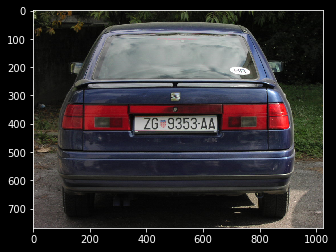

<Figure size 864x720 with 0 Axes>

In [3]:
img_test = cv2.imread('img/P9170030.jpg')
height, width, channel = img_test.shape

plt.imshow(cv2.cvtColor(img_test, cv2.COLOR_BGR2RGB))
plt.figure(figsize=(12, 10))                           # figure 함수 위치에 따라 크기 적용 여부 달라짐
plt.show()

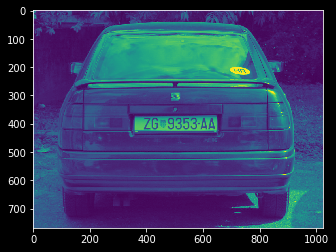

<Figure size 864x720 with 0 Axes>

In [4]:
img_gray = cv2.cvtColor(img_test, cv2.COLOR_BGR2GRAY)

plt.imshow(img_gray)
plt.figure(figsize=(12, 10))
plt.show()

<br>

## Erosion & Dilation (침식과 팽창)

<Figure size 864x720 with 0 Axes>

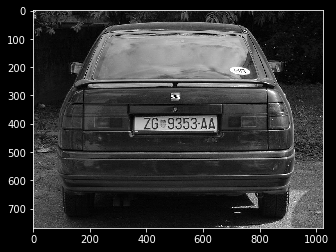

<Figure size 864x720 with 0 Axes>

In [5]:
# 직사각형 모양으로 3X3 크기의 커널 매트릭스를 생성해줌
structuringElement = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))

# 모폴로지: 이미지의 침식과 팽창 관련 함수
# TOPHAT: 원본이미지와 '열기' 한 이미지의 차이를 보여줌
# BLACKHAT: 원본이미지와 '닫기' 한 이미지의 차이를 보여줌
imgTopHat = cv2.morphologyEx(img_gray, cv2.MORPH_TOPHAT, structuringElement)
imgBlackHat = cv2.morphologyEx(img_gray, cv2.MORPH_BLACKHAT, structuringElement)


imgGrayscalePlusTopHat = cv2.add(img_gray, imgTopHat)        # 순서: 입력영상, 더하기할 영상
gray = cv2.subtract(imgGrayscalePlusTopHat, imgBlackHat) # 순서: 입력영상, 빼기할 영상

plt.imshow(gray, cmap='gray')
plt.figure(figsize=(12, 10))

<br>

## Thresholding

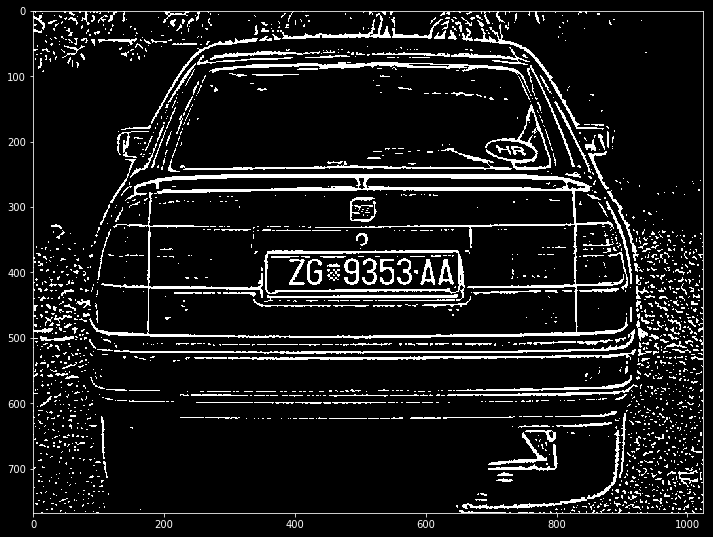

In [6]:
img_blurred = cv2.GaussianBlur(gray, ksize=(5,5), sigmaX =0)

img_thresh = cv2.adaptiveThreshold(img_blurred, maxValue=255.0, 
                                   adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   thresholdType=cv2.THRESH_BINARY_INV, 
                                   blockSize=19, C=9)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

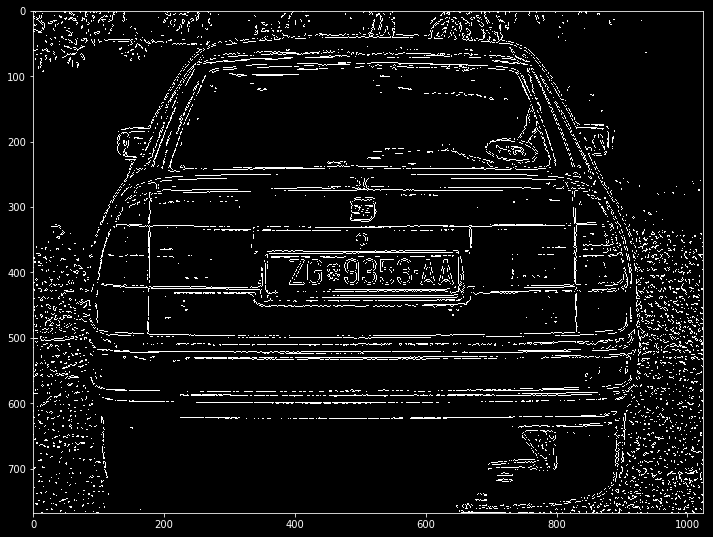

In [7]:
_, contours, hierarchy = cv2.findContours(img_thresh, mode=cv2.RETR_LIST, method=cv2.CHAIN_APPROX_SIMPLE)

# 내사진의 3D행렬을 제로스??
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

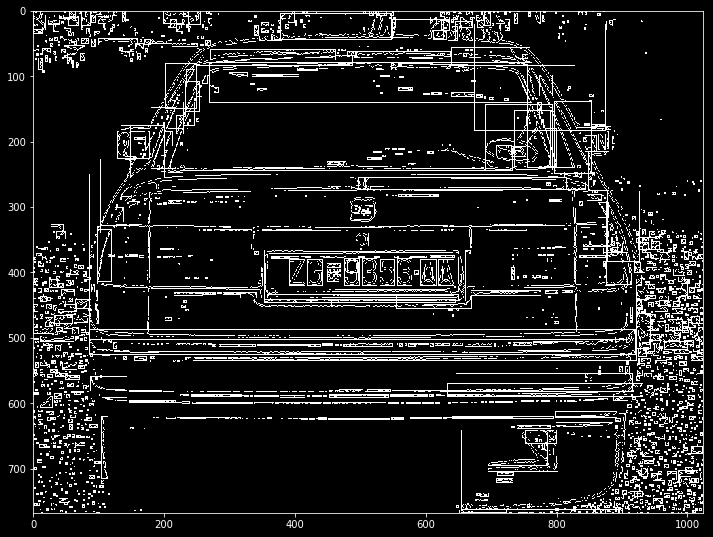

In [9]:
contours_dict = []

# 컨투어 데이터에서 사각형 데이터를 찾는다.
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y),  pt2=(x+w, y+h), color=(255, 255, 255))
    
    # dict 안에 넣는 과정
    contours_dict.append({'contour': contour, 'x': x, 'y': y, 'w': w, 'h': h,
                          'cx': x + (w/2), 'cy': y + (h/2)})

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

<br>

## 후보군 찾기

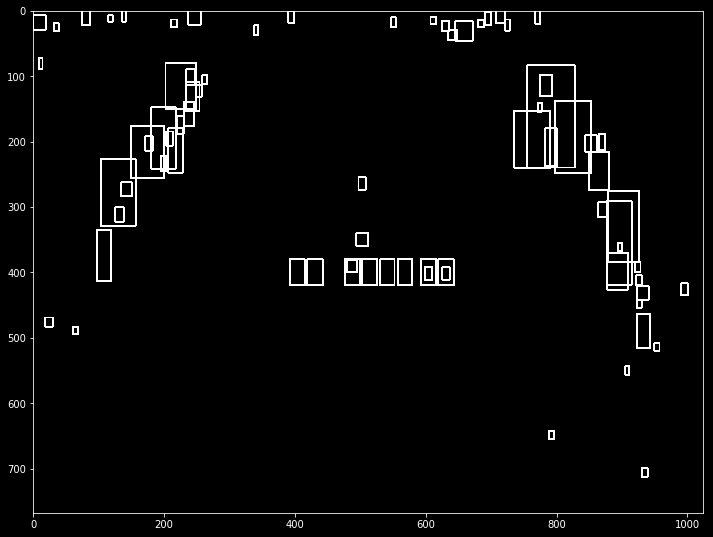

In [10]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 1.0

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']),
                  color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')